# Panagram + r-index

In [2]:
from dash import Dash, dcc, html, Input, Output
import subprocess
import plotly.graph_objects as go
import numpy as np
from collections import Counter


In [3]:
num_docs = 4
colors = ['#fde725', '#5cc863', '#21908d', '#3b518b', '#440154']


In [4]:
def call_query(genome_region, k):
    start, end = genome_region
    region = "NZ_CP015023.1:" + str(start) + "-" + str(end)
    cmd = [
        "/home/stephen/Documents/projects/langmead_lab/omem/src/query.sh",
        "-k", str(k),
        "-n", "4",
        "-o", "/home/stephen/Documents/projects/langmead_lab/omem/data/example_dap",
        "-b", "omem.bed.gz",
        "-r", "omem_olaps_NZ_CP015023.1_0_5506800.bed",
        "-p"
        ]
    subprocess.check_call(cmd)
    return 1


In [5]:

def update_data(genome_region, k, n_bins):
    call_query(genome_region, k)
    bed_dir = '/home/stephen/Documents/projects/langmead_lab/omem/data/example_dap/'
    MEM_bed_path = bed_dir + 'omem_' + str(k) + 'mer.bed'
    mem_bed = pd.read_csv(MEM_bed_path, sep='\t', header=None, names=['chrm', 'start', 'end', 'order'])

    positions = list(mem_bed.index)
    num_orders = len(set(mem_bed['order']))
    mem_bed_order_matrix = np.zeros((num_orders+1, len(positions)))

    for order in range(num_orders):
        mem_bed_order_subset = mem_bed[mem_bed['order'] == order+1]
        for start, end in zip(mem_bed_order_subset['start'], mem_bed_order_subset['end']):
            mem_bed_order_matrix[order, start:end] = 1
    mem_bed_order_matrix[order+1,:] = 1
    num_docs_per_pos = np.argmax(mem_bed_order_matrix, axis=0)

    per_bin_doc_composition_list = []
    bin_space = list(map(int,np.linspace(0, len(positions), n_bins)))

    for bin_idx, start_end in enumerate(list(zip(bin_space[:-1], bin_space[1:]))):
        bin_start, bin_end = start_end
        doc_count_per_order_in_bin = Counter(num_docs_per_pos[bin_start : bin_end])
        for doc_no_count in set(range(0,num_docs+1)) - set(doc_count_per_order_in_bin.keys()):
            doc_count_per_order_in_bin[doc_no_count] = 0
        normalized_doc_count_per_order_in_bin = [(order, cnt/sum(doc_count_per_order_in_bin.values())) for order, cnt in doc_count_per_order_in_bin.items()]
        normalized_doc_count_per_order_in_bin_in_sorted_order_mem_order = sorted(normalized_doc_count_per_order_in_bin, key=lambda x: x[0])   # sorting by order
        per_bin_doc_composition_list.append([bin_idx]+[norm_cnt[1] for norm_cnt in normalized_doc_count_per_order_in_bin_in_sorted_order_mem_order])

    cnames = ['pos', '1', '2', '3', '4', '5']
    per_bin_doc_composition_df = pd.DataFrame(per_bin_doc_composition_list, columns=cnames)
    per_bin_doc_composition_df = pd.melt(per_bin_doc_composition_df, id_vars=['pos'], value_vars=cnames[1:])
    per_bin_doc_composition_df.columns = ['bin','Num docs','value']

    per_bin_doc_composition_df['Num docs'] = pd.Categorical(per_bin_doc_composition_df['Num docs'], categories=cnames[:0:-1])

    return per_bin_doc_composition_df

In [ ]:
app = Dash(__name__)

genome_size = 5506800

app.layout = html.Div([
    html.H4('Panagram + r-index'),
    html.P("Genome region:"),
    dcc.RangeSlider(0, genome_size, value=[0, genome_size], allowCross=False, id="genome_region"),
    html.P("Number bins:"),
    dcc.Input(id="n_bins", type="number", value=700, debounce=True, placeholder="Number of bins"),
    dcc.Graph(id="panagram_graph"),
    html.P("K:"),
    dcc.Slider(min=10, max=20, value=12, step=1, id="K_slider")
])

@app.callback(
    Output("panagram_graph", "figure"),
    Input('genome_region', 'value'),    # genome region
    Input("K_slider", "value"),         # k
    Input("n_bins", "value"))           # n_bins
def update_bar_chart(genome_region, k, n_bins):
    start, end = genome_region
    # run query
    data = update_data(genome_region, k, n_bins)

    fig = go.Figure()
    for doc_idx in range(1, num_docs+2):
        doc_data = data[data['Num docs'] == str(doc_idx)]
        x, y = doc_data['bin'], doc_data['value']
        color = dict(color=colors[doc_idx-1])
        name = str(doc_idx)

        fig.add_trace(go.Bar(x=x, y=y, name = name,
                             legendgroup="Num docs",
                             legendgrouptitle_text="Num docs",
                             marker=color,
                             marker_line=color))

    fig.update_layout(barmode='stack', bargap=0.0, template="simple_white",
                      title={'text': str(k) + '-mers conservation',
                            'x':0.5, 'xanchor': 'center', 
                            'yanchor': 'bottom'})
    
    fig.update_xaxes(title_text="Position",
                     tickvals = np.linspace(0, n_bins-2, num=10),
                     ticktext = list(map(int, np.linspace(0, genome_region[1], num=10)))
                     )
    fig.update_yaxes(title_text="Proportion " + str(k) + "-mers conserved")

    return fig

app.run_server(debug=True,  use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on

omem query - query k-mers on order MEMs of input bed file region
Usage: ./omem query [options]

Basic options:
  -k [INT]               k-mer size [12]
  -n [INT]               number of other (non-pivot) documents in pangenome
  -r [FILE]              bed file of target query region
  -o [FILE]              output directory ['/.']
  -s                     sort bed output



In [ ]:
#tick_pos = np.linspace(0, n_bins-2, num=10)
#tick_val = list(map(int, np.linspace(0, genome_region[1], num=10)))

fig = go.Figure()
for doc_idx in range(1, num_docs+2):
    doc_data = data[data['Num docs'] == str(doc_idx)]
    x, y = doc_data['bin'], doc_data['value']
    color = dict(color=colors[doc_idx-1])
    name = str(doc_idx)

    fig.add_trace(go.Bar(x=x, y=y, name = name,
                         legendgroup="Num docs",
                         legendgrouptitle_text="Num docs",
                         marker=color,
                         marker_line=color))

fig.update_layout(barmode='stack', bargap=0.0, template="simple_white",
                  title={'text': str(k) + '-mers conservation',
                        'x':0.5, 'xanchor': 'center',
                        'yanchor': 'bottom'})

fig.update_xaxes(title_text="Position",
                 tickvals = np.linspace(0, n_bins-2, num=10),
                 ticktext = np.linspace(0, n_bins-2, num=10)
                ),
fig.update_yaxes(title_text="Proportion " + str(k) + "-mers conserved")



In [8]:
# the x-axis
# should range from length of the genome

genome_size = 5506800

genome_region = (0,5506800)
k = 13
n_bins = 701
data = update_data(genome_region, k, n_bins)
data




omem query - query k-mers on order MEMs of input bed file region
Usage: ./omem query [options]

Basic options:
  -k [INT]               k-mer size [12]
  -n [INT]               number of other (non-pivot) documents in pangenome
  -r [FILE]              bed file of target query region
  -o [FILE]              output directory ['/.']
  -s                     sort bed output



,bin,Num docs,value
0,0,1,0.497063
1,1,1,0.461817
2,2,1,0.395212
3,3,1,0.436512
4,4,1,0.451423
...,...,...,...
3495,695,5,0.034794
3496,696,5,0.028468
3497,697,5,0.025745
3498,698,5,0.016268


In [47]:
tmp = list(map(int, genome_size / (699 - data['bin']) ) )
tmp

OverflowError: cannot convert float infinity to integer

In [16]:
data['bin']

0         0
1         1
2         2
3         3
4         4
       ... 
3495    695
3496    696
3497    697
3498    698
3499    699
Name: bin, Length: 3500, dtype: int64

In [9]:
tmp = genome_size / (699 - data['bin'])
tmp = tmp.replace(np.inf, 0)
# set all inf as 0
data['pos'] = list(map(int, tmp))
data


,bin,Num docs,value,pos
0,0,1,0.497063,7878
1,1,1,0.461817,7889
2,2,1,0.395212,7900
3,3,1,0.436512,7912
4,4,1,0.451423,7923
...,...,...,...,...
3495,695,5,0.034794,1376700
3496,696,5,0.028468,1835600
3497,697,5,0.025745,2753400
3498,698,5,0.016268,5506800


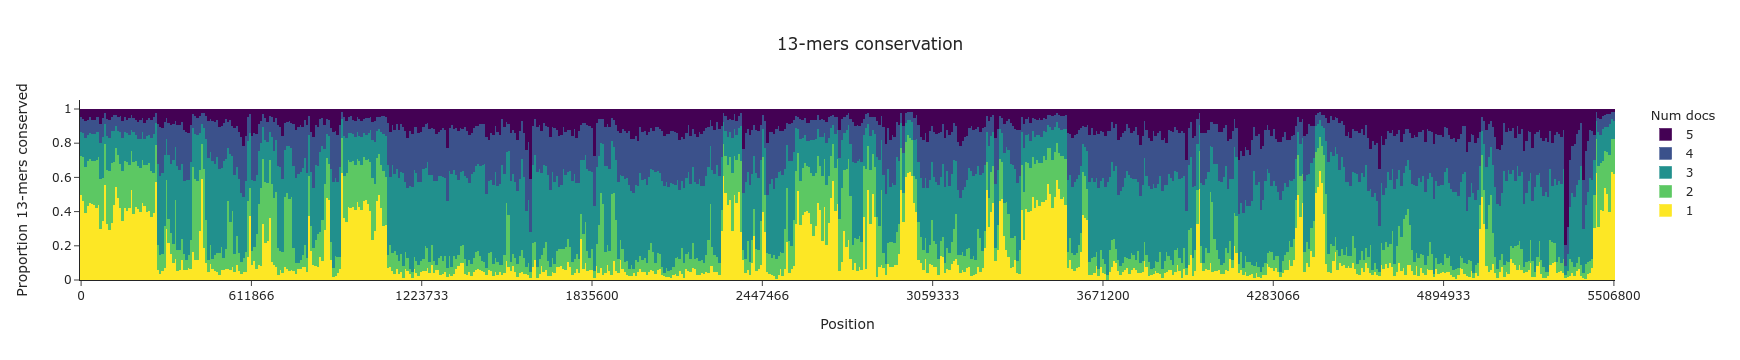

In [64]:
tick_pos = np.linspace(0, n_bins-2, num=10)
tick_val = list(map(int, np.linspace(0, genome_region[1], num=10)))

fig = go.Figure()
for doc_idx in range(1, num_docs+2):
    doc_data = data[data['Num docs'] == str(doc_idx)]
    x, y = doc_data['bin'], doc_data['value']
    color = dict(color=colors[doc_idx-1])
    name = str(doc_idx)

    fig.add_trace(go.Bar(x=x, y=y, name = name,
                         legendgroup="Num docs",
                         legendgrouptitle_text="Num docs",
                         marker=color,
                         marker_line=color))

fig.update_layout(barmode='stack', bargap=0.0, template="simple_white",
                  title={'text': str(k) + '-mers conservation',
                        'x':0.5, 'xanchor': 'center',
                        'yanchor': 'bottom'})

fig.update_xaxes(title_text="Position",
                 tickvals = tick_pos,
                 ticktext = tick_val
                ),
fig.update_yaxes(title_text="Proportion " + str(k) + "-mers conserved")



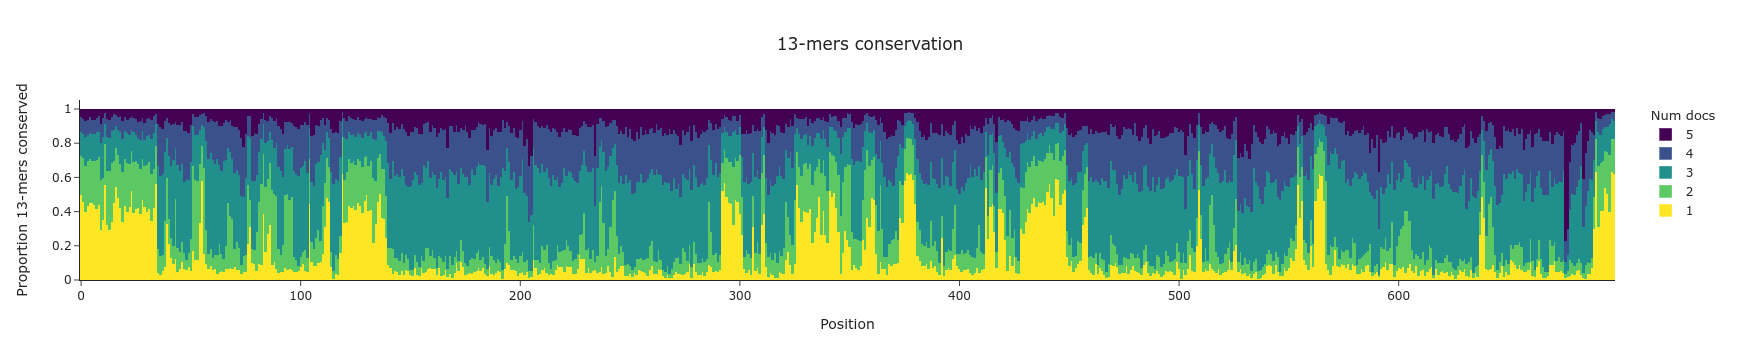

In [10]:
fig = go.Figure()
for doc_idx in range(1, num_docs+2):
    doc_data = data[data['Num docs'] == str(doc_idx)]
    x, y = doc_data['bin'], doc_data['value']
    color = dict(color=colors[doc_idx-1])
    name = str(doc_idx)

    fig.add_trace(go.Bar(x=x, y=y, name = name,
                         legendgroup="Num docs",
                         legendgrouptitle_text="Num docs",
                         marker=color,
                         marker_line=color))

fig.update_layout(barmode='stack', bargap=0.0, template="simple_white",
                  title={'text': str(k) + '-mers conservation', # (chr:' + str(start) + '-' + str(end) + ')',
                        'x':0.5, 'xanchor': 'center',
                        'yanchor': 'bottom'})
#fig.update_xaxes(title_text="Bin (n=" + str(n_bins) +')')
fig.update_xaxes(title_text="Position")
fig.update_yaxes(title_text="Proportion " + str(k) + "-mers conserved")
